<a href="https://colab.research.google.com/github/tuanaasuokturk/MBC_data_analysis/blob/main/Tutorial_psychometric_curves_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Psychometric curves - Tutorial

# Introduction

In this tutorial, we consider a toy example from a sensory discrimination task. The idea is to introduce the concepts of a psychometric curve and likelihood estimation before we apply them to a more complex dataset.

Our behavioral dataset corresponds to a standard two-alternative forced-choice task, where on each trial subjects have to report on the direction of motion of a stimulus with a binary response (left or right). The stimulus strength (or stimulus evidence) is varied across trial.

We want to describe how the subject's response (left or right) depends on the evidence strength.

# Summary statistics: the psychometric curve
A natural way of summarizing the subject's responses in a sensory tasks with binary choices, is to extract the **psychometric curve**, corresponding to the proportion of rightward choices as a function of stimulus evidence. We plot the psychometric curve below. See how it captures the relationship between stimulus and choice.

In [ ]:
# first, import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as optimize
import ipywidgets as widgets       # interactive display

In [ ]:
# load the data (change to local path if you're working locally)
df_exp = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC_data_analysis/main/A3_PsychometricCurves/dataset_tutorial.csv",sep=',')
df_exp.head()

,stimulus,response
0,3.0,1
1,2.0,1
2,1.0,1
3,3.0,1
4,1.0,1


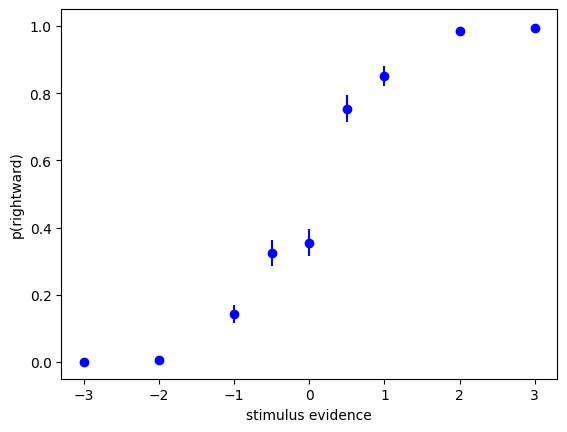

In [ ]:
#define function to plot psychometric curve
def plot_data_psychometric(df):
    """
    Plots the psychometric function separately for control and deactivation trials.
    Args:
       df (dataframe): dataset.
    """
    # plot psychometric curve for control trials
    df.groupby('stimulus').response.agg(('mean','sem')).plot(yerr='sem', fmt = 'bo', ax=plt.gca(), legend=False);

    plt.xlabel('stimulus evidence');
    plt.ylabel('p(rightward)');

# apply the function on the experimental dataframe
plot_data_psychometric(df_exp)

# Fit a psychometric function


## Logistic function
The plot above summarize the dependence of perceptual choices for a few different values of the stimulus evidence. We would like to formalize this into a simple model that captures the statistical relationship between the stimulus strength and the choice. More specifically, the model will characterize the probability of a rightward choice $p(r=1|s)$ as a function of the stimulus evidence $s$. We cannot use a simple linear relationship $p(r=1|s) = w_0 + w_1 s$ because this would predict that as $s$ goes to infinity (either $+ \infty$ or $-\infty$), $p(right)$ would also go to infinity. But $p(r=1|s)$ is a probability so it is **bounded between 0 and 1**. So we need to introduce a non-linearity that maps all continuous values onto values in the range [0 1]. This is obtained by using a sigmoidal function. A classical example of sigmoidal function is the logistic function $\sigma$:
<br>
$\sigma(x) = \frac{1}{1+ e^{-x}}$
<br>
You really don't need to know (or understand) the formula, but here is how the function looks like:


<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2917245761.py:18: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma(x)$');


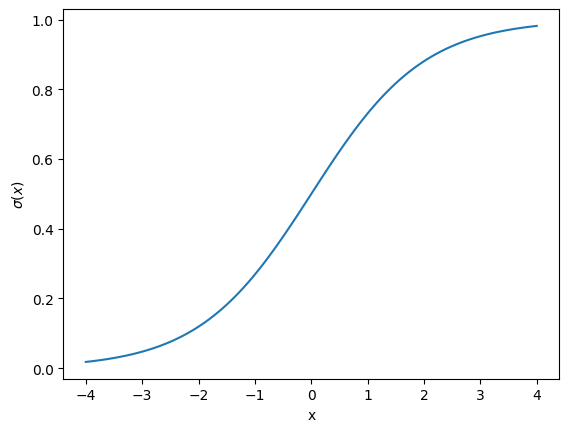

In [ ]:
# let's define the logistic function
def logistic(x):
    y = 1 / (1 + np.exp(-x))
    return y

# to plot a function, we first make an array with many values (here 100)
# paving all the space in a certain range (here, from -4 to 4)
X = np.linspace(-4,4,100)

# then we compute the value of the function at each of these values
Y = logistic(X)

# and then we just plot the curve joining the dots: easy!
plt.plot(X,Y,'-');

# (and don't forget the labels)
plt.xlabel('x');
plt.ylabel('$\sigma(x)$');

See, a sigmoidal function with values bounded between 0 and 1, just as we wanted! <br>
You can evaluate the function at different values just so you see you understand how it works:

In [ ]:
print(logistic(0))

0.5


Now, we will plug our linear model $p(r=1|s) = w_0 + w_1 s$ into this sigmoidal function, which gives us the formula: <br>
$p(r=1|s) = \sigma(w_0 + w_1 d) = \frac{1}{1+ e^{-(w_0 + w_1 d)}}$

This is our psychometric model. It gives a probability of response = 1 (rightward choice) as a function of stimulus strength $s$. It has two parameters $w_0$ and $w_1$, similarly to simple linear regression. We'll see their role in a minute.


In [ ]:

# define probability of rightward choices according to logistic model
def psychometric_model(s, w0, w1):
    """
    Computes the probability of rightward choices according to the logistic model
    Args:
        s (list): sensory evidence, for each trial
        w0 (scalar): regression weight
        w1 (scalar): regression weight
    Returns:
        list: probability of rightward choice, for each trial
    """

    # probability of rightward choice in control and manipulated condition
    p = logistic(w0 + w1 * s)

    return p

# Plot psychometric function at continuous values, for given model
def plot_model(w0, w1):

    # define 100 angle points linearly spaced between -3 and 3
    s_linspace = np.linspace(-3,3,100)

    p_standard = psychometric_model(s_linspace, w0, w1)

    # plot fitted psychometric functions
    plt.plot(s_linspace, p_standard, 'b')

    plt.ylabel('p(rightward)')



## 1. Naive fitting

A naive fitting procedure is to adjust manually the parameters in the model to try to visually match the experimental and theoretical psychometric curves. Here we just adjust the parameters by hand so that the predicted value captures the summary statistics qualitatively.
One of the benefit of using a statistical model is to draw predictions for experimental conditions not seen in the original dataset (i.e., the response to stimulus values that have not been presented to the subjects).

**Now use the widget below to adjust parameters to yield the best possible fit between experimental and theoretical psychometric curves. Is the fit good enough?**

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(
    w0 = widgets.FloatSlider(0.0, min=-2.0, max=2.0), # default, min and max values for noise variance param
    w1 = widgets.FloatSlider(0.5, min=0.0, max=2.0)) # defaul, min and max values for lapse parameter

def plot_data_estimate(w0, w1):

    # plot model predictions
    plot_model(w0, w1)

    # plot psychometric curve on top
    plot_data_psychometric(df_exp)

    plt.show(); # needed for Colab


interactive(children=(FloatSlider(value=0.0, description='w0', max=2.0, min=-2.0), FloatSlider(value=0.5, desc…

## 2. Likelihood function
Now we will use a more principled approach to parameter estimation by looking for the set of parameters that maximize a given metric, namely the **log-likelihood** of the data. The likelihood function is a function, defined for a given model and dataset, that takes the **parameters as input**.
Complete the following function to compute the log-likelihood of model for a given set of parameters.

In [ ]:
def LogLikelihood(df, w0, w1):
    """
    Computes the log-likelihood of model with certain parameter set
    Args:
        df (dataframe): dataset
        w0 (scalar): model parameter
        w1 (scalar): model parameter
    Returns:
        scalar: log-likelihood of model
    """
    # p of rightward choice for each trial in dataset, according to the model
    p = psychometric_model(df.stimulus, w0, w1)

    # likelihood for each trial (=p if choice is rightward, 1-p otherwise)
    lh = np.where(df.response==1, p, 1-p)

    # Handle division by zero
    lh = np.where(lh == 0, np.finfo(float).eps, lh)

    # log-likelihood for whole dataset (sum of log-likelihood of individual trials)
    LLH = np.sum(np.log(lh))

    return LLH

Compute the log-likelihood at the values of the parameters obtained by naive fitting.

In [ ]:
llh_B = LogLikelihood(df_exp, w0=0.4, w1=1.3)
print(llh_B)

-450.8423359935108


## 3. Maximum likelihood estimation



Now that we have a function of parameters that defines a metric for how well the model accounts for the data, we can identify the maximum-likelihood parameters by using an **optimization algorithm** over the LLH function. Because most optimization tools are defined for minimization rather than maximization, we will actually minimize the negative Log-Likelihood (which is equivalent to maximize the LLH).


In [ ]:
# Define the objective function (the to be maximized)
def neg_LLH(pp, df):
    """
    Computes the neg-LLH for the model.
    Args:
        - pp (list): set of parameters (sigma_d,Lambda)
        - df (dataframe): dataset
    Returns;
        - scalar: negative LLH
    """
    return -LogLikelihood(df, pp[0], pp[1])

# Define the bounds for each variable
bounds = [(-10.0, 10.0), (0.001, 10)]  # Example bounds: w0 between -10 and +10; w1 between 0.001 and 10

# Initial guess for parameter set
x0 = [0.75, 0.5]

# Perform the optimization with bounds
result = optimize.minimize(neg_LLH, x0=x0, args=(df_exp), bounds=bounds)

# Retrieve the optimized parameters
(w0_hat, w1_hat) = result.x

# print
print("w0_hat =",w0_hat)
print("w1_hat =",w1_hat)
print("LLH =",LogLikelihood(df_exp,w0_hat,w1_hat))


w0_hat = -0.0990647145927685
w1_hat = 1.8989905876188655
LLH = -411.19480060768024


**Now, let's plot the data again and plot the best fitting psychometric function (the maximum likelihood estimate).**

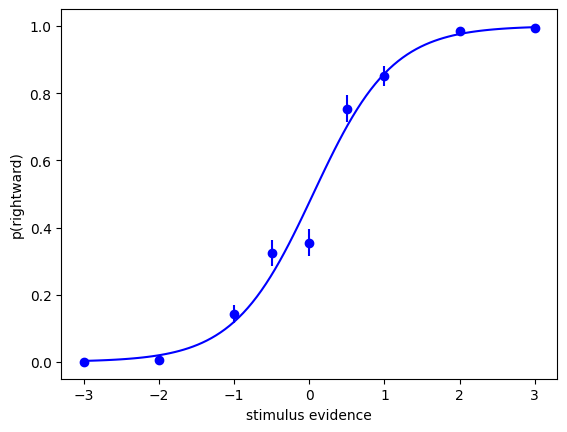

In [ ]:
plot_data_estimate(w0_hat, w1_hat)

Voila! You can compare this fit to what you got above by adjusting the parameters by hand. Note that maximum likehood estimation is a very general and powerful tool, we can apply it to all problems where we can compute the likelihood of the data given some model. For example, we could use a more complex psychometric function with more parameters (e.g. a lapse rate).

## 4. Visual the likelihood function (optional)

To get a better intuition about the likelihood function and the optimization procedure, we will plot the value of the LLH as a function of both parameters, as a coloured plot. We'll add the maximum likelihood parameters as a red dot on the LLH profile.


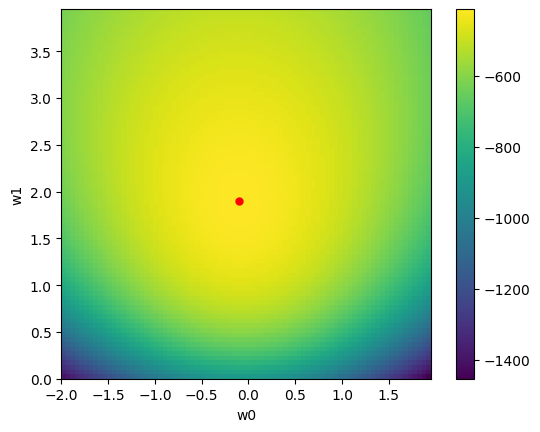

In [ ]:
# define linearly space values of Lambda and sigma
w0 = np.arange(-2, 2, 0.05)
w1 = np.arange(0, 4.0, 0.05)

# compute all possible pairs of parameter values (defining a grid)
W0, W1 = np.meshgrid(w0, w1)

# compute LLH for each of these parameter sets
LLH = np.zeros(W0.shape)
for j in range(W0.shape[0]):
    for k in range(W0.shape[1]):
        LLH[j,k] = LogLikelihood(df_exp, w0=W0[j,k], w1=W1[j,k])

# define function to plot Log-Likelihood profile
def show_LL(LLH,w0,w1):
    im=plt.imshow(np.flipud(LLH), extent=[w0[0],w0[-1],w1[0],w1[-1]]);
    plt.ylabel('w1')
    plt.xlabel('w0')
    plt.colorbar(im)


# plot LLH profile
show_LL(LLH,w0,w1)

# add MLE parameters as red dot
plt.plot(w0_hat, w1_hat, marker='o', markersize=5, color='red');
